<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Text_neural2/TextClassification_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'telegram-spam-or-ham:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4641655%2F7902951%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240821%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240821T182639Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D48b2b79705dfbb61ef8d4e75f21ba23350cc9dd538f038b866763fbb09edb31617a28a80062df850a738e64f6bb230268fefafb734ef53ab94d0bd19eca7bd6e0dc961cf09a34f486b665260879df3f08d648be84f6b06f0206bd6bccd437468885d4d4c33148147b0edcd6eee532584893e8ebe332da6832dae3acd06291f8e299b7db24d1a4f014adeb7ec17aba6d87780fc0533c91bb8565e4ad94188b3cd1c76002bc287e1aa7fd5c36b5a7bb8ffa6d661ad00245f820a9c5d974477427bf811028306dead164e6eb6d2491d118136dd4ec7eeb9c369355acf0ede95cc2bb24c9a6dad7483ba00527ab9f7211da4e113bcef2e3a7746a2aa3a813aa72103'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


[==================================================] 2257668 bytes downloaded
Downloaded and uncompressed: telegram-spam-or-ham
Data source import complete.


In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input\telegram-spam-or-ham\dataset.csv


In [86]:
df = pd.read_csv('/kaggle/input/telegram-spam-or-ham/dataset.csv')
df.rename(columns={'text_type': 'labels'}, inplace=True)
df

,labels,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...
...,...,...
20343,ham,/ban
20344,ham,/ban
20345,ham,/ban
20346,ham,Kaisi hii


In [87]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext
from torchtext.vocab import GloVe


class MyDataset(Dataset):
    def __init__(self, X, y, max_len=200):
        self.X = X
        self.y = y
        self.max_len = max_len

        self.label_encoder = LabelEncoder().fit(y)
        self.vocab = torchtext.vocab.GloVe(name='840B', dim=300)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)

        text = self.X.iloc[idx]
        tokens = text.split()

        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)

            tokens += ['<pad>'] * diff

        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)

        return X, label[0]


dataset = MyDataset(df['text'], df['labels'])

In [88]:
dataset[0][0].shape

torch.Size([200, 300])

In [89]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [90]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [91]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import math
from torch import Tensor


# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(1, max_len, d_model)
#         pe[0, :, 0::2] = torch.sin(position * div_term)
#         pe[0, :, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Arguments:
#             x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
#         """
#         x = x + self.pe[:, :x.size(1)]
#         return self.dropout(x)

In [92]:
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()

        #self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim * max_len, num_classes)

    def forward(self, x):
        #out = self.pos_encoder(x)
        out = self.encoder(x)
        out = self.flatten(out)
        out = self.linear1(out)
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(encoding_dim=300, max_len=200, num_classes=2).to(device)
model

TextClassifier(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=300, bias=True)
        (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=60000, out_features=2, bias=True)
)

In [93]:
params_num = 0

for param in model.parameters():
    size = param.size()

    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

521166

In [94]:
class_counts = df['labels'].value_counts().sort_index().values

weights = 1.0 / class_counts
weights = torch.FloatTensor(weights).to(device)

In [95]:
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)

In [96]:
weights

tensor([6.9750e-05, 1.6636e-04], device='cuda:0')

In [97]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device).float()
            y    = batch[1].to(device).long()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device).float()
                y    = batch[1].to(device).long()
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [98]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=30,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.000010), epochs=30, device=cuda

Epoch    1   24sec	loss:      0.394	val_loss:      0.319	accuracy_score:       0.83	val_accuracy_score:      0.863	
Epoch    2   25sec	loss:      0.271	val_loss:      0.282	accuracy_score:      0.895	val_accuracy_score:      0.882	
Epoch    3   25sec	loss:       0.23	val_loss:      0.242	accuracy_score:      0.911	val_accuracy_score:      0.899	
Epoch    4   25sec	loss:      0.201	val_loss:      0.227	accuracy_score:      0.924	val_accuracy_score:      0.913	
Epoch    5   25sec	loss:      0.181	val_loss:      0.213	accuracy_score:      0.931	val_accuracy_score:      0.915	
Epoch    6   25sec	loss:      0.168	val_loss:      0.204	accuracy_score:      0.937	val_accuracy_score:      0.912	
Epoch    7   25sec	loss:      0.155	val_loss:        0.2	accuracy_score:      0.941	val_accuracy_score:      0.922	
Epoch    8   25sec	loss:      0.146	val_loss:      0.192	accuracy_score:      0.945	val_accuracy_score

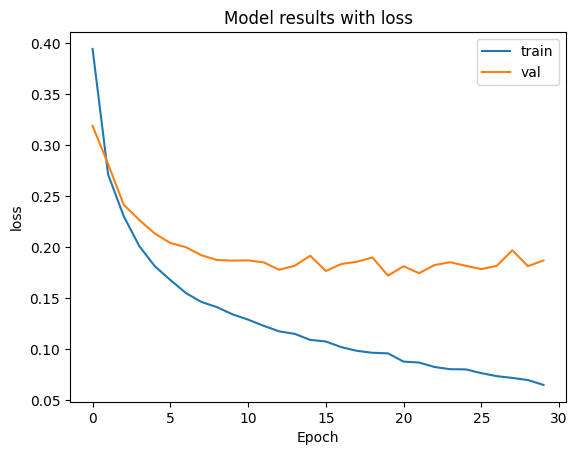

In [99]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

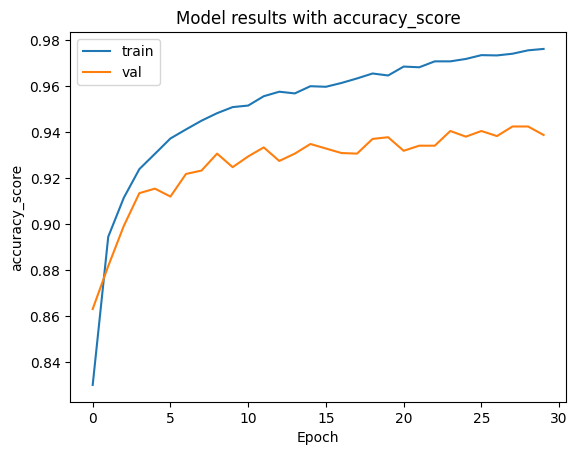

In [100]:
plot_metric(history, 'accuracy_score')

[]

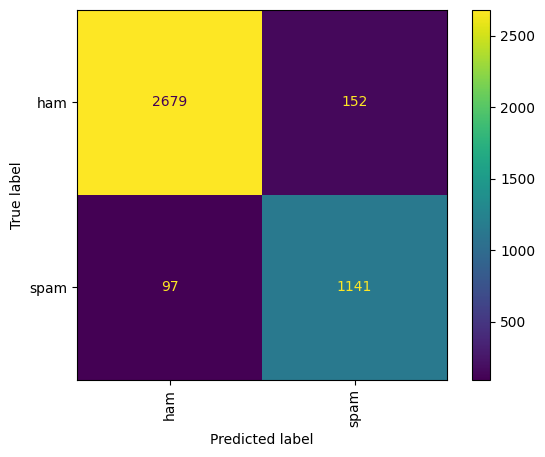

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

In [102]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.label_encoder.classes_))

              precision    recall  f1-score   support

         ham       0.97      0.95      0.96      2831
        spam       0.88      0.92      0.90      1238

    accuracy                           0.94      4069
   macro avg       0.92      0.93      0.93      4069
weighted avg       0.94      0.94      0.94      4069

